In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('deep'))
plt.rcParams['figure.figsize'] = (20 , 10)


## derivative of a fn with single input:


Slope at 3: 14.011999999999247


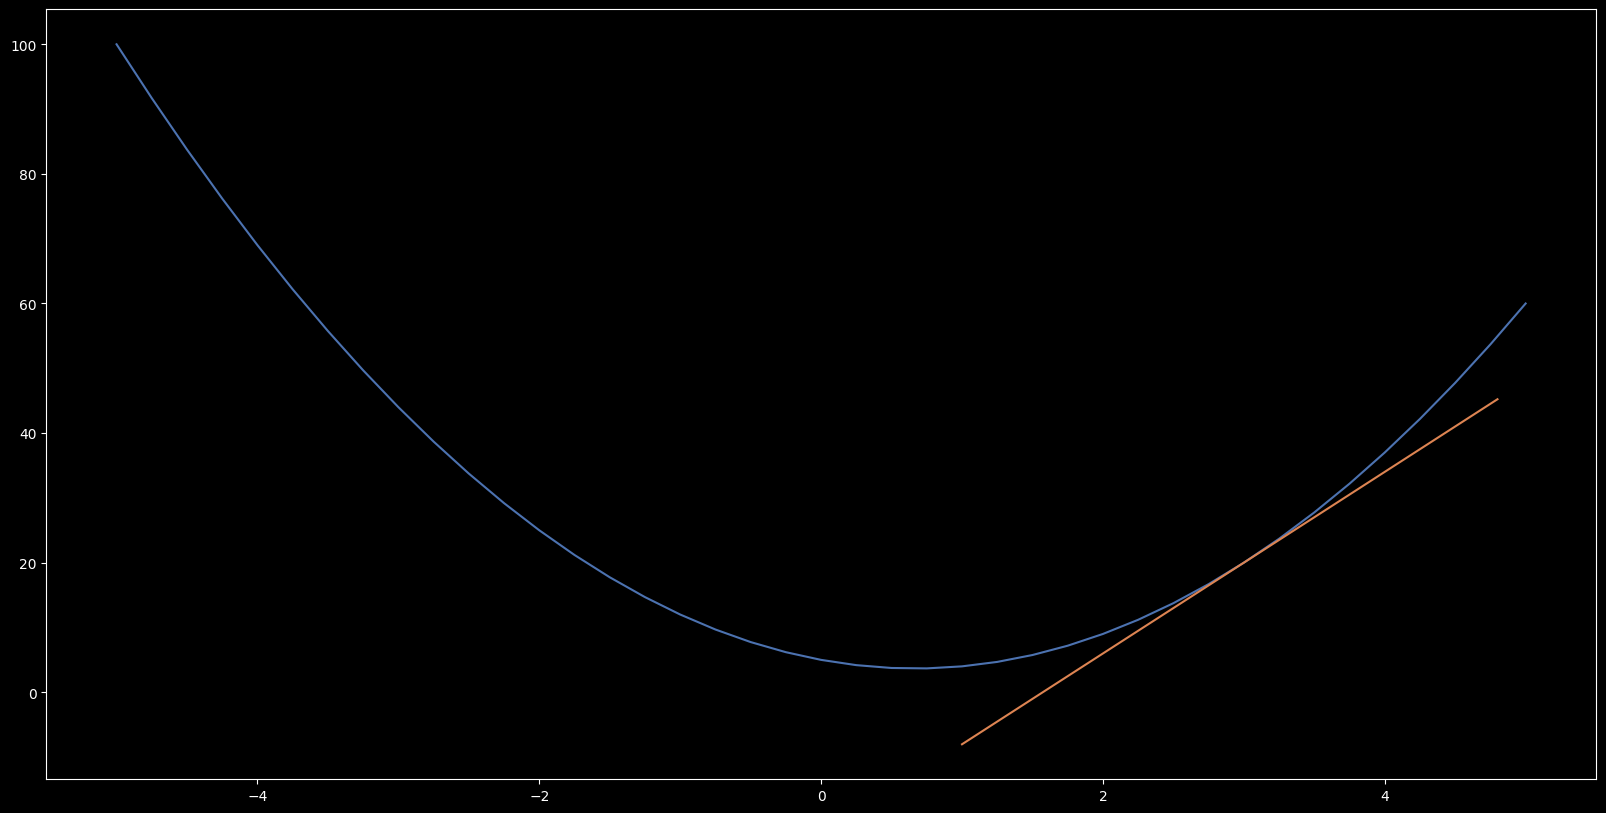

In [10]:
x = np.arange(-5,5.25 , 0.25)
def f(x):
    return 3*x**2 - 4*x + 5

#plot the derivative at a point:
xi = 3
delta = 0.004

yd = (f(xi + delta) - f(xi)) / delta
c = f(xi) - (yd * xi)

xirange = np.arange(xi - 2 , xi + 2 , 0.2)
tangent = xirange * yd + c

print(f"Slope at {xi}: {yd}")
plt.plot(x , f(x))
plt.plot(xirange , tangent)
plt.show()

## derivative with multiple inputs:


In [11]:
a =2 
b = -3.0 
c = 10
d = a * b + c
b += 0.001
d1 = a * b + c
slope = (d1 - d) / a
print(f"{slope}")

0.0009999999999998899


In [105]:
class Value():
    def __init__(self , data , children = () , _op = "", label = "" , grad = 0):
        self.data = data
        self.children = set(children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
         


    def __repr__(self):
        return f"Value(data = {self.data} , label = {self.label})"
    
    def __add__(self , other):
        other = other if isinstance(other , Value) else Value(other)
        out =  Value(self.data + other.data , (self , other) , "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __radd__(self , other):
        return self + other
    
    def __mul__(self , other):
        other = other if isinstance(other , Value) else Value(other)
        out =  Value(self.data * other.data , (self , other) , "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self , other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out =  Value(t , (self,) , 'tanh')

        def _backward():
            self.grad += (1 - out.data **2) * out.grad

        out._backward = _backward
        return out  
    
    def exp(self):
        out = Value(np.exp(self.data) , (self,) , 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self , other):
        assert isinstance(other , (int , float))
        out = Value(self.data ** other , (self,) , f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self , other):
        other = other if isinstance(other, Value) else Value(float(other))
        return self * other ** -1
    

    def __neg__(self):
        return self * -1

    def __sub__(self , other):
        other = other if isinstance(other, Value) else Value(float(other))
        return self + (-other)

    def backprop(self):
        nodes = []
        visited = set()
        self.grad = 1
        def topo(node):
            if node in visited: return
            visited.add(node)
            for child in node.children:
                topo(child)
            nodes.append(node)

        topo(self)
        # print(nodes)
        for node in reversed(nodes):
            node._backward()
    

In [106]:
a = Value(2)


In [108]:
#plot the operations graph:
from graphviz import Digraph

def trace(root):
    nodes , edges = set() , set()
    def build(node):
        # print(node)
        if node not in nodes:
            nodes.add(node)
            for child in node.children:
                edges.add((child , node))
                build(child)
    build(root)
    return nodes , edges


def toposort(root):

    nodes = []
    visited = set()

    def dfs(node):
        if node in visited:
            return
        visited.add(node)
        nodes.append(node)
        
        for child in node.children:
            dfs(child)

        
    dfs(root)
    return nodes , visited


def drawg(root):
    dot = Digraph(format = 'svg' , graph_attr={'rankdir':'LR'})

    nodes , edges = trace(root)

    for node in nodes:
        uid = str(id(node))
        dot.node(name = uid , label = f"label:{node.label} | data:{node.data} | grad:{node.grad}" , shape = 'record')

        if node._op:
            dot.node(name = uid + node._op , label = node._op)
            dot.edge(uid + node._op , uid)

    for n1 , n2 in edges:
        dot.edge(str(id(n1)) , str(id(n2)) + n2._op)

    return dot


# for node in e.children:
#     print(node)

In [109]:
def buildg():
    #inputs:
    x = Value(2.0 , label = 'x')
    y = Value(0.0 , label = 'y')

    #weights:
    w1 = Value(-3 , label = 'w1')
    w2 = Value(1 , label = 'w2')
    #bias
    # b = Value(6.881373587019 , label = 'b')

    # matmul:

    xw1 = x * w1; xw1.label = 'xw1'
    yw2 = y * w2; yw2.label = 'yw2'
    xw1yw2 = xw1 + yw2; xw1yw2.label = 'xw1yw2'
    z = xw1yw2 +  b; z.label = 'z'
    ##############
    # o = z.tanh(); o.label = 'o'
    e = (2 * z).exp(); e.label = 'e'
    o = (e - 1) / (e + 1); o.label = 'o'
    ##############
    return o , drawg(o)

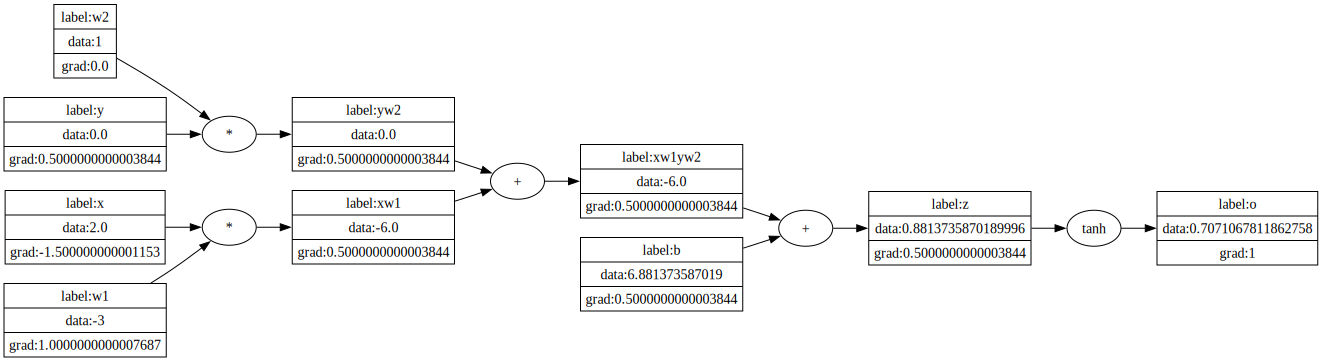

In [110]:
#inputs:
x = Value(2.0 , label = 'x')
y = Value(0.0 , label = 'y')

#weights:
w1 = Value(-3 , label = 'w1')
w2 = Value(1 , label = 'w2')
#bias
b = Value(6.881373587019 , label = 'b')

#matmul:

xw1 = x * w1; xw1.label = 'xw1'
yw2 = y * w2; yw2.label = 'yw2'
xw1yw2 = xw1 + yw2; xw1yw2.label = 'xw1yw2'
z = xw1yw2 +  b; z.label = 'z'
##############
o = z.tanh(); o.label = 'o'
o.grad = 1
o.backprop()
drawg(o)

## implementation using torch:


In [111]:
import torch

In [112]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373]).double(); b.requires_grad = True
n = w1*x1 + w2 * x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print("-"*40)
print(f"{x1.grad.item()=} , {w1.grad.item()=} , {x2.grad.item()=} , {w2.grad.item()=}")

0.7071064519863152
----------------------------------------
x1.grad.item()=-1.500001396677975 , w1.grad.item()=1.00000093111865 , x2.grad.item()=0.500000465559325 , w2.grad.item()=0.0


In [125]:
import random
class Neuron:
    def __init__(self , nin):
        self.w = [Value(random.uniform(-1 , 1)) for i in range(nin)]
        self.b = Value(random.uniform(-1 , 1))

    def __call__(self , x):
        z = sum((wi * xi for wi , xi in zip(self.w , x)) , self.b)
        return z.tanh()
    

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self , nin , nout):
        self.neurons = [Neuron(nin) for i in range(nout)]


    def __call__(self , x):
        outvec = [neuron(x) for neuron in self.neurons]
        return outvec[0] if len(outvec) == 1 else outvec
    

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]

class MLP:
    def __init__(self , nin , nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

    def __call__(self , x):
        for layer in self.layers:
            x = layer(x)
        return x
    

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

x = [2, 3]
nn = MLP(len(x) , [ 2, 1])
y = nn(x)
y.backprop()
# drawg(y)
nn.parameters() , len(nn.parameters())

([Value(data = 0.3022731998403452 , label = ),
  Value(data = 0.058975549038355 , label = ),
  Value(data = -0.711771419302389 , label = ),
  Value(data = -0.514844852826221 , label = ),
  Value(data = 0.06733468952388688 , label = ),
  Value(data = 0.8022797402795807 , label = ),
  Value(data = 0.3427844930276074 , label = ),
  Value(data = 0.43202999605921377 , label = ),
  Value(data = 0.33574630578693276 , label = )],
 9)

In [208]:
xs = [[2.0 , 3.0 , -1.0] ,
      [3.0 , -1.0 , 0.5],
      [0.5 , 1.0 , 1.0],
      [1 , 1, -1]]

ys = [1 , -1 , -1 , 1]

nn = MLP(3 , [5 , 5, 2, 1])

In [209]:
#forward apass
n = 20
for iter in range(n):
    ypred = [nn(x) for x in xs]
    loss = np.mean([(yp - yi)**2 for yp , yi in zip(ypred , ys)])
    # print(f"{loss=}")

    for params in nn.parameters():
        params.grad = 0
    loss.backprop()

    for params in nn.parameters():
        # print(params)
        params.data += -0.1 * params.grad
    
    print(f"{iter+1} , {loss.data}")

1 , 1.4074938637151186
2 , 1.1559620658935224
3 , 0.9673713447939384
4 , 0.8528944243564068
5 , 0.7653544484206787
6 , 0.6905298600995807
7 , 0.6133809345257267
8 , 0.5253868529325703
9 , 0.4337677217367094
10 , 0.35152444600494925
11 , 0.284827626456331
12 , 0.2333494582045802
13 , 0.19419544179434842
14 , 0.16429424837424633
15 , 0.14116810147813522
16 , 0.12299562588287799
17 , 0.10847938749178329
18 , 0.09669995274524101
19 , 0.08700130664503211
20 , 0.07890962194263657


In [ ]:
loss.children.pop()

0.25